# Frequency Analysis
This examples shows how to perform a Modified Fourier Transform (MFT), or a Frequency Modifies Fourier Transform (FMFT) on timeseries data using REBOUND. 

In [1]:
import rebound
import numpy as np
sim = rebound.Simulation()
rebound.data.add_outer_solar_system(sim)
sim.integrator = "whfast"
sim.dt = sim.particles[1].P/30.13 # About 30 steps per Jupiter orbit

We now integrate this forward in time, taking snapshots about every 120000 days.

In [2]:
step = int(120000.0/365.25*np.pi*2/sim.dt)
sim.save_to_file("output.bin",step=step,delete_file=True)
Nsamples = 2**13
sim.integrate(step*sim.dt*(Nsamples-1),exact_finish_time=False)

We now have a Simulationarchive with $2^{13}$ snaphots.

In [3]:
sa = rebound.Simulationarchive("output.bin")
print(sa)

<rebound.simulationarchive.Simulationarchive object at 0x7279f4372250, nblobs=8192, reb_version=4.4.11>


We can now extract the eccentricity and the periastron of Jupiter from this archive.

In [4]:
inp = np.zeros(Nsamples*2)
for i, sim in enumerate(sa):
    o = sim.particles[1].orbit()
    inp[i*2+0] = o.e*np.cos(o.pomega)
    inp[i*2+1] = o.e*np.sin(o.pomega)

Let's quickly plot this dataset.

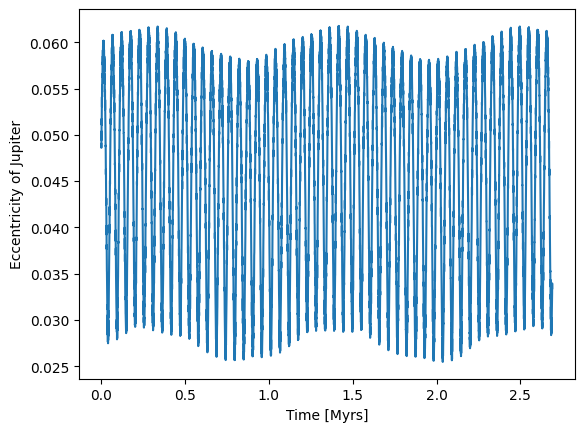

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel("Time [Myrs]")
ax.set_ylabel("Eccentricity of Jupiter")
ax.plot(np.arange(Nsamples)*step*sim.dt/np.pi/2.0/1e6,np.sqrt(inp[::2]**2+inp[1::2]**2));

Next, we perform the Frequency Modified Fourier Transform algorithm on this time series to extraxt the secular frequencies, amplitudes, and phases.

In [11]:
minfreq = 60.0/1296000.0*step*sim.dt
out = rebound.frequency_analysis(inp, type=1, minfreq=-minfreq, maxfreq=minfreq)

The following table lists the 10 most dominant frequencies in the signal. Also shown are the amplitudes and the phases.

In [27]:
nfreq = len(out)//3
for i in range(nfreq):
    nu = out[0*nfreq+i]*1296000.0/step/sim.dt
    A = out[1*nfreq+i]
    phi = out[2*nfreq+i]/np.pi*180.0
    print("nu = %5.2f\"/yr   A = %.7f   phi = %5.1f°" % (nu, A, phi))

nu =  4.24"/yr   A = 0.0441150   phi =  30.0°
nu = 28.24"/yr   A = 0.0156774   phi = 306.1°
nu =  3.09"/yr   A = 0.0018430   phi = 119.5°
nu = 52.25"/yr   A = 0.0005711   phi =  42.2°
nu = 29.29"/yr   A = 0.0002578   phi = 253.3°
nu = 27.18"/yr   A = 0.0002552   phi = 183.9°
nu =  5.35"/yr   A = 0.0000729   phi = 135.4°
nu = 53.36"/yr   A = 0.0000541   phi = 325.2°
nu =  4.17"/yr   A = 0.0000483   phi =  75.7°
nu = 51.18"/yr   A = 0.0000191   phi = 282.4°


We can use these dominant frequencies to create an approximation of the input data.